In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import MinMaxScaler


In [3]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [5]:
input_path = '/Users/charisoneyemi/Downloads/THESISFOLDER/FinalDataset/clustering_work.csv'
df = pd.read_csv(input_path, parse_dates=['First_Purchase', 'Last_Purchase'])

In [7]:
print(f"Dataset loaded: {df.shape}")
print(f"Columns available: {df.columns.tolist()}")

Dataset loaded: (5027, 35)
Columns available: ['Response ID', 'First_Purchase', 'Last_Purchase', 'Purchase_Days', 'Total_Quantity', 'Total_Spent', 'Unique_Products', 'Unique_Categories', 'Recency_Days', 'Frequency', 'Avg_Order_Value', 'Avg_Quantity_Per_Order', 'Age Group', 'Hispanic Origin', 'Race', 'Education', 'Household Income', 'Gender Identity', 'Sexual Orientation', 'State Reported', 'Account Shared With', 'Household Size', 'Amazon Order Frequency', 'Smoke Cigarettes', 'Smoke Marijuana', 'Drink Alcohol', 'Diabetes', 'Wheelchair', 'Opinion: Amazon Sell Data', 'Opinion: Companies Sell Data', 'Opinion: SMB Data Access', 'Opinion: Census Use Data', 'Opinion: Research Use Data', 'Behavior_Segment', 'CLV_Predicted']


In [9]:
numeric_features = [
    'Unique_Products', 'Unique_Categories',
    'Recency_Days', 'Frequency', 'Avg_Order_Value', 'Avg_Quantity_Per_Order'
]

In [11]:
categorical_features = [
    'Age Group', 'Hispanic Origin', 'Race', 'Education', 'Household Income',
    'Gender Identity', 'Sexual Orientation', 'State Reported',
    'Account Shared With', 'Household Size', 'Amazon Order Frequency',
    'Smoke Cigarettes', 'Smoke Marijuana', 'Drink Alcohol', 'Diabetes', 'Wheelchair',
    'Opinion: Amazon Sell Data', 'Opinion: Companies Sell Data',
    'Opinion: SMB Data Access', 'Opinion: Census Use Data', 'Opinion: Research Use Data',
    'Behavior_Segment'
]

In [13]:
behavioral_features = [
    'Avg_Quantity_Per_Order',
    'Avg_Order_Value',
    'Frequency',
    'Recency_Days',
    'Unique_Categories',
    'Unique_Products',
    'Total_Spent'
]

In [15]:
X = df[numeric_features + categorical_features]
y = df['Total_Spent']

# Revenue concentration by segment

In [18]:
total_revenue = df['Total_Spent'].sum()
for segment in [0, 1]:
    subset = df[df['Behavior_Segment'] == segment]
    seg_revenue = subset['Total_Spent'].sum()
    percentage = (seg_revenue / total_revenue) * 100
    print(f"\nSegment {segment}:")
    print(f"  Total Revenue: ${seg_revenue:,.2f}")
    print(f"  Revenue Share: {percentage:.1f}% of total")
    print(f"  Number of Customers: {len(subset):,}")
    print(f"  Average CLV: ${subset['Total_Spent'].mean():,.2f}")


Segment 0:
  Total Revenue: $18,643,616.81
  Revenue Share: 42.3% of total
  Number of Customers: 3,897
  Average CLV: $4,784.09

Segment 1:
  Total Revenue: $25,410,016.31
  Revenue Share: 57.7% of total
  Number of Customers: 1,130
  Average CLV: $22,486.74


# Demographic breakdown by segment

In [21]:
demo_features = ['Age Group', 'Education', 'Household Income', 'Gender Identity']
for segment in [0, 1]:
    print(f"\n--- SEGMENT {segment} ---")
    for feature in demo_features:
        if feature in df.columns:
            mode_value = df[df['Behavior_Segment'] == segment][feature].mode()
            if len(mode_value) > 0:
                count = df[df['Behavior_Segment'] == segment][feature].value_counts()
                print(f"{feature}: {mode_value[0]} (n={count.iloc[0]})")


--- SEGMENT 0 ---
Age Group: 25 - 34 years (n=1473)
Education: Bachelor's degree (n=1704)
Household Income: $25,000 - $49,999 (n=1016)
Gender Identity: Female (n=1920)

--- SEGMENT 1 ---
Age Group: 35 - 44 years (n=368)
Education: Bachelor's degree (n=515)
Household Income: $100,000 - $149,999 (n=284)
Gender Identity: Female (n=669)


# Segment-specific prediction accuracy

In [24]:
for segment in [0, 1]:
    segment_mask = df['Behavior_Segment'] == segment
    
    y_true_seg = df[segment_mask]['Total_Spent']
    y_pred_seg = df[segment_mask]['CLV_Predicted']
    
    rmse_seg = mean_squared_error(y_true_seg, y_pred_seg, squared=False)
    mae_seg = mean_absolute_error(y_true_seg, y_pred_seg)
    r2_seg = r2_score(y_true_seg, y_pred_seg)
    
    print(f"\nSegment {segment} Prediction Performance:")
    print(f"  RMSE: ${rmse_seg:.2f}")
    print(f"  MAE: ${mae_seg:.2f}")
    print(f"  R²: {r2_seg:.4f}")


Segment 0 Prediction Performance:
  RMSE: $250.59
  MAE: $81.91
  R²: 0.9955

Segment 1 Prediction Performance:
  RMSE: $2620.66
  MAE: $844.62
  R²: 0.9490


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# Summary statistics by segment

In [27]:
segment_stats = df.groupby('Behavior_Segment')[behavioral_features].agg(['mean', 'std', 'min', 'max'])
print("\n", segment_stats)


                  Avg_Quantity_Per_Order                                 \
                                   mean       std       min        max   
Behavior_Segment                                                         
0                              2.223512  1.026641  1.000000  16.791667   
1                              2.828038  1.426449  1.377778  17.900000   

                 Avg_Order_Value                                    \
                            mean        std        min         max   
Behavior_Segment                                                     
0                      52.873373  26.983699   1.840000  368.875600   
1                      60.458654  25.873551  20.134879  321.314412   

                   Frequency              ... Unique_Categories       \
                        mean         std  ...               min  max   
Behavior_Segment                          ...                          
0                  97.257634   74.882984  ...               

# Overall dataset summary

In [30]:
print(f"Total Customers: {len(df):,}")
print(f"Total Revenue: ${total_revenue:,.2f}")
print(f"Average CLV: ${df['Total_Spent'].mean():,.2f}")
print(f"Median CLV: ${df['Total_Spent'].median():,.2f}")
print(f"CLV Standard Deviation: ${df['Total_Spent'].std():,.2f}")
print(f"\nDate Range: {df['First_Purchase'].min().date()} to {df['Last_Purchase'].max().date()}")

Total Customers: 5,027
Total Revenue: $44,053,633.12
Average CLV: $8,763.40
Median CLV: $5,706.99
CLV Standard Deviation: $9,782.76

Date Range: 2018-01-01 to 2024-08-15


In [34]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("Set2")

# Cluster Validation Metrics 

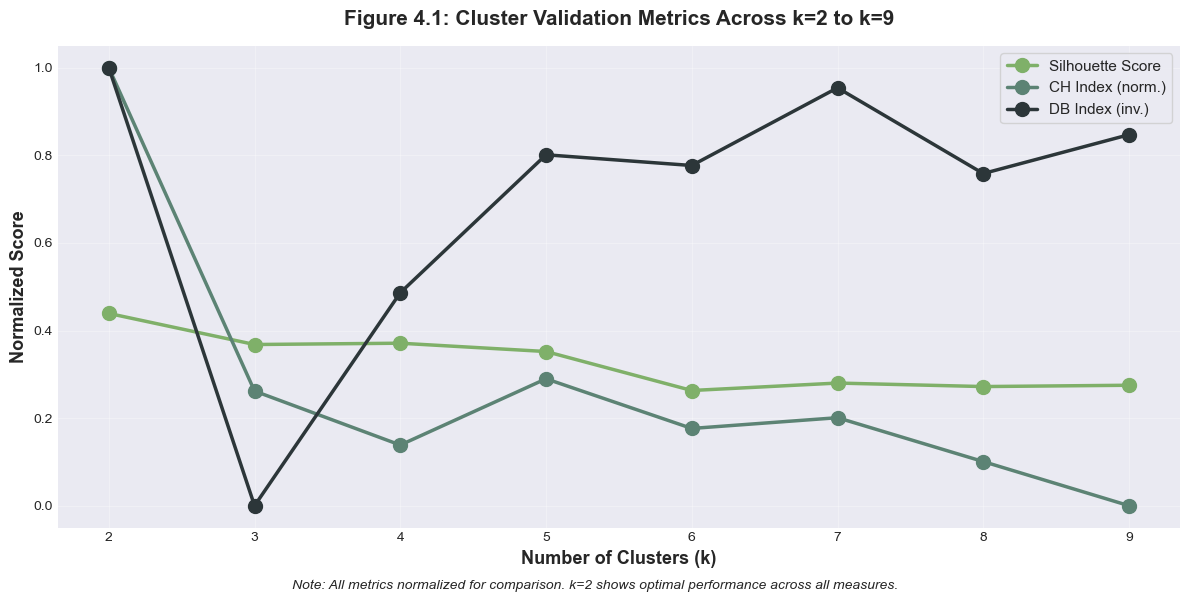

Figure 4.1 saved


In [61]:
k_values = list(range(2, 10))
sil_scores = [0.439, 0.368, 0.371, 0.352, 0.263, 0.280, 0.272, 0.275]
ch_scores = [2680.5, 1976.8, 1859.3, 2003.5, 1895.4, 1918.8, 1823.3, 1727.3]
db_scores = [0.996, 1.323, 1.164, 1.061, 1.069, 1.011, 1.075, 1.046]

#Normalizing CH and invert DB for comparison
ch_normalized = (np.array(ch_scores) - min(ch_scores)) / (max(ch_scores) - min(ch_scores))
db_normalized = (np.array(db_scores) - min(db_scores)) / (max(db_scores) - min(db_scores))

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(k_values, sil_scores, marker='o', label='Silhouette Score', 
        linewidth=2.5, markersize=10, color='#7FB069')
ax.plot(k_values, ch_normalized, marker='o', label='CH Index (norm.)', 
        linewidth=2.5, markersize=10, color='#5C8374')
ax.plot(k_values, db_inverted, marker='o', label='DB Index (inv.)', 
        linewidth=2.5, markersize=10, color='#2C3639')

ax.set_xlabel('Number of Clusters (k)', fontsize=13, fontweight='bold')
ax.set_ylabel('Normalized Score', fontsize=13, fontweight='bold')
ax.set_title('Figure 4.1: Cluster Validation Metrics Across k=2 to k=9', 
             fontsize=15, fontweight='bold', pad=15)
ax.legend(loc='best', fontsize=11, frameon=True)
ax.grid(True, alpha=0.3)
ax.set_xticks(k_values)

fig.text(0.5, 0.01, 'Note: All metrics normalized for comparison. k=2 shows optimal performance across all measures.', 
         ha='center', fontsize=10, style='italic')

plt.tight_layout(rect=[0, 0.02, 1, 1])
plt.savefig('figure_4_1_cluster_validation.png', dpi=300, bbox_inches='tight')
plt.show()
print("Figure 4.1 saved")

In [69]:
from sklearn.preprocessing import StandardScaler

behavioral_features = [
    'Avg_Quantity_Per_Order',
    'Avg_Order_Value',
    'Frequency',
    'Recency_Days',
    'Unique_Categories',
    'Unique_Products',
    'Total_Spent'
]

X_behav = df[behavioral_features].copy()

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_behav)


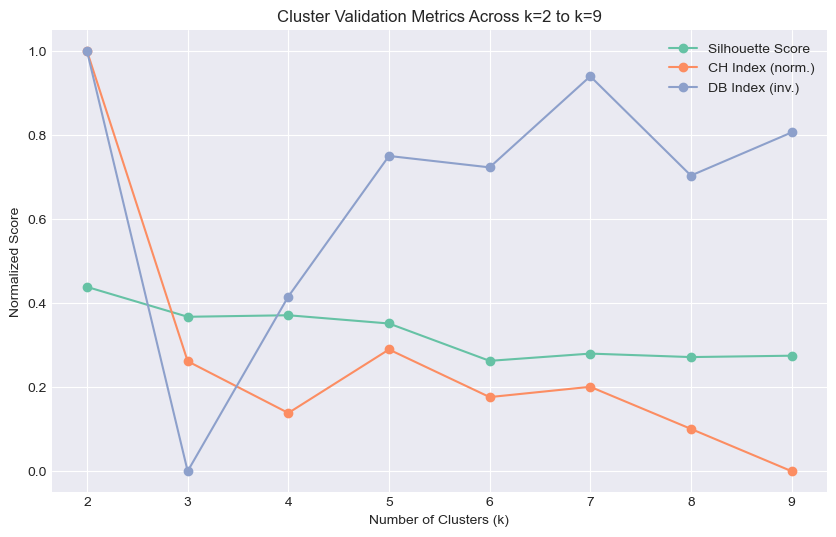

In [71]:
k_values = range(2, 10)
sil_scores, ch_scores, db_scores = [], [], []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE)
    labels = kmeans.fit_predict(X_scaled)
    sil_scores.append(silhouette_score(X_scaled, labels))
    ch_scores.append(calinski_harabasz_score(X_scaled, labels))
    db_scores.append(davies_bouldin_score(X_scaled, labels))

# Normalize CH and DB (after inversion for DB)
scaler = MinMaxScaler()
ch_norm = scaler.fit_transform(np.array(ch_scores).reshape(-1,1)).flatten()
db_inv = [1/x for x in db_scores]  # invert DB (smaller = better → larger = better)
db_norm = scaler.fit_transform(np.array(db_inv).reshape(-1,1)).flatten()

plt.figure(figsize=(10,6))
plt.plot(k_values, sil_scores, marker='o', label='Silhouette Score')
plt.plot(k_values, ch_norm, marker='o', label='CH Index (norm.)')
plt.plot(k_values, db_norm, marker='o', label='DB Index (inv.)')

plt.xlabel("Number of Clusters (k)")
plt.ylabel("Normalized Score")
plt.title("Cluster Validation Metrics Across k=2 to k=9")
plt.legend()
plt.grid(True)
plt.show()


# Comprehensive Segment Profile

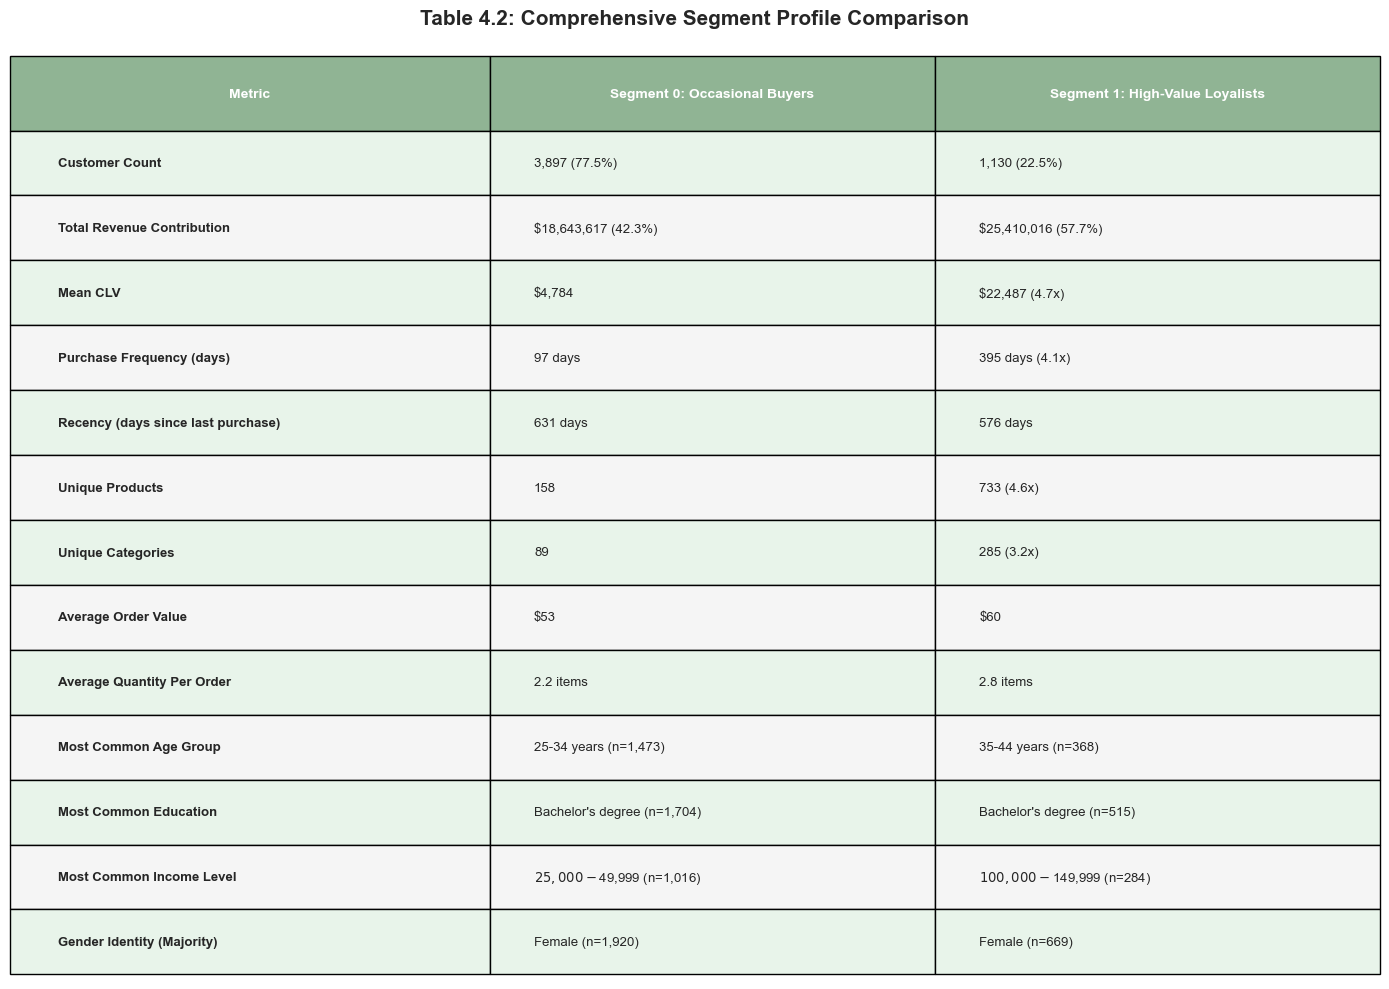

Table 4.2 saved


In [50]:
comparison_data = {
    'Metric': [
        'Customer Count',
        'Total Revenue Contribution',
        'Mean CLV',
        'Purchase Frequency (days)',
        'Recency (days since last purchase)',
        'Unique Products',
        'Unique Categories',
        'Average Order Value',
        'Average Quantity Per Order',
        'Most Common Age Group',
        'Most Common Education',
        'Most Common Income Level',
        'Gender Identity (Majority)'
    ],
    'Segment 0: Occasional Buyers': [
        '3,897 (77.5%)',
        '$18,643,617 (42.3%)',
        '$4,784',
        '97 days',
        '631 days',
        '158',
        '89',
        '$53',
        '2.2 items',
        '25-34 years (n=1,473)',
        "Bachelor's degree (n=1,704)",
        '$25,000-$49,999 (n=1,016)',
        'Female (n=1,920)'
    ],
    'Segment 1: High-Value Loyalists': [
        '1,130 (22.5%)',
        '$25,410,016 (57.7%)',
        '$22,487 (4.7x)',
        '395 days (4.1x)',
        '576 days',
        '733 (4.6x)',
        '285 (3.2x)',
        '$60',
        '2.8 items',
        '35-44 years (n=368)',
        "Bachelor's degree (n=515)",
        '$100,000-$149,999 (n=284)',
        'Female (n=669)'
    ]
}

table_df = pd.DataFrame(comparison_data)

fig, ax = plt.subplots(figsize=(14, 10))
ax.axis('tight')
ax.axis('off')

table = ax.table(cellText=table_df.values,
                colLabels=table_df.columns,
                cellLoc='left',
                loc='center',
                colWidths=[0.35, 0.325, 0.325])

table.auto_set_font_size(False)
table.set_fontsize(9.5)
table.scale(1, 2.5)

for i in range(len(table_df.columns)):
    cell = table[(0, i)]
    cell.set_facecolor('#90B494')
    cell.set_text_props(weight='bold', color='white', fontsize=10)
    cell.set_height(0.08)

for i in range(len(table_df)):
    for j in range(len(table_df.columns)):
        cell = table[(i+1, j)]
        if i % 2 == 0:
            cell.set_facecolor('#E8F4EA')
        else:
            cell.set_facecolor('#F5F5F5')
        cell.set_height(0.07)
        
        # Bold first column (metric names)
        if j == 0:
            cell.set_text_props(weight='bold', fontsize=9.5)

plt.title('Table 4.2: Comprehensive Segment Profile Comparison', 
          fontsize=15, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('table_4_2_segment_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("Table 4.2 saved")

# Model Performance Summary

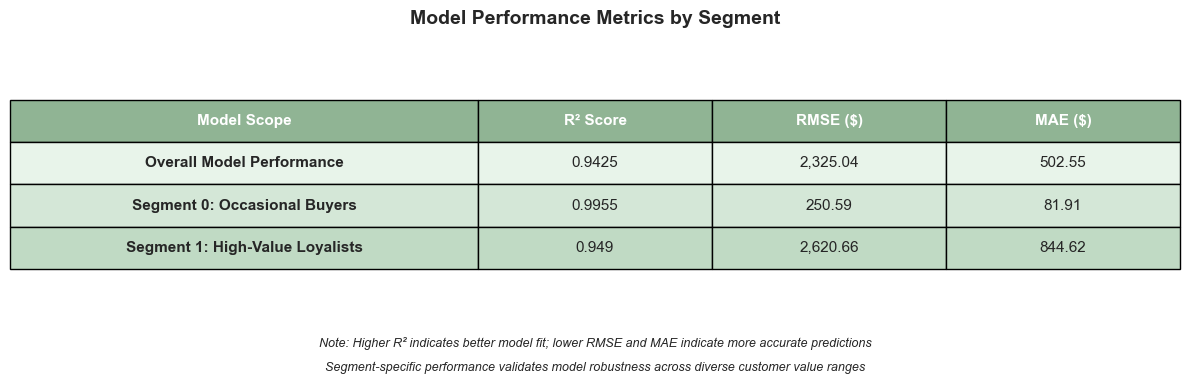

Model Performance Table saved


In [52]:
perf_data = {
    'Model Scope': [
        'Overall Model Performance',
        'Segment 0: Occasional Buyers',
        'Segment 1: High-Value Loyalists'
    ],
    'R² Score': [0.9425, 0.9955, 0.9490],
    'RMSE ($)': ['2,325.04', '250.59', '2,620.66'],
    'MAE ($)': ['502.55', '81.91', '844.62']
}

perf_df = pd.DataFrame(perf_data)

fig, ax = plt.subplots(figsize=(12, 4))
ax.axis('tight')
ax.axis('off')

table = ax.table(cellText=perf_df.values,
                colLabels=perf_df.columns,
                cellLoc='center',
                loc='center',
                colWidths=[0.4, 0.2, 0.2, 0.2])

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2.8)

for i in range(len(perf_df.columns)):
    cell = table[(0, i)]
    cell.set_facecolor('#90B494')
    cell.set_text_props(weight='bold', color='white')

colors = ['#E8F4EA', '#D4E7D7', '#C0DAC4']
for i in range(len(perf_df)):
    for j in range(len(perf_df.columns)):
        cell = table[(i+1, j)]
        cell.set_facecolor(colors[i])
        if j == 0:  # Bold first column
            cell.set_text_props(weight='bold')

plt.title('Model Performance Metrics by Segment', fontsize=14, fontweight='bold', pad=15)
fig.text(0.5, 0.12, 'Note: Higher R² indicates better model fit; lower RMSE and MAE indicate more accurate predictions', 
         ha='center', fontsize=9, style='italic')
fig.text(0.5, 0.06, 'Segment-specific performance validates model robustness across diverse customer value ranges', 
         ha='center', fontsize=9, style='italic')

plt.tight_layout(rect=[0, 0.14, 1, 1])
plt.savefig('model_performance_table.png', dpi=300, bbox_inches='tight')
plt.show()
print("Model Performance Table saved")

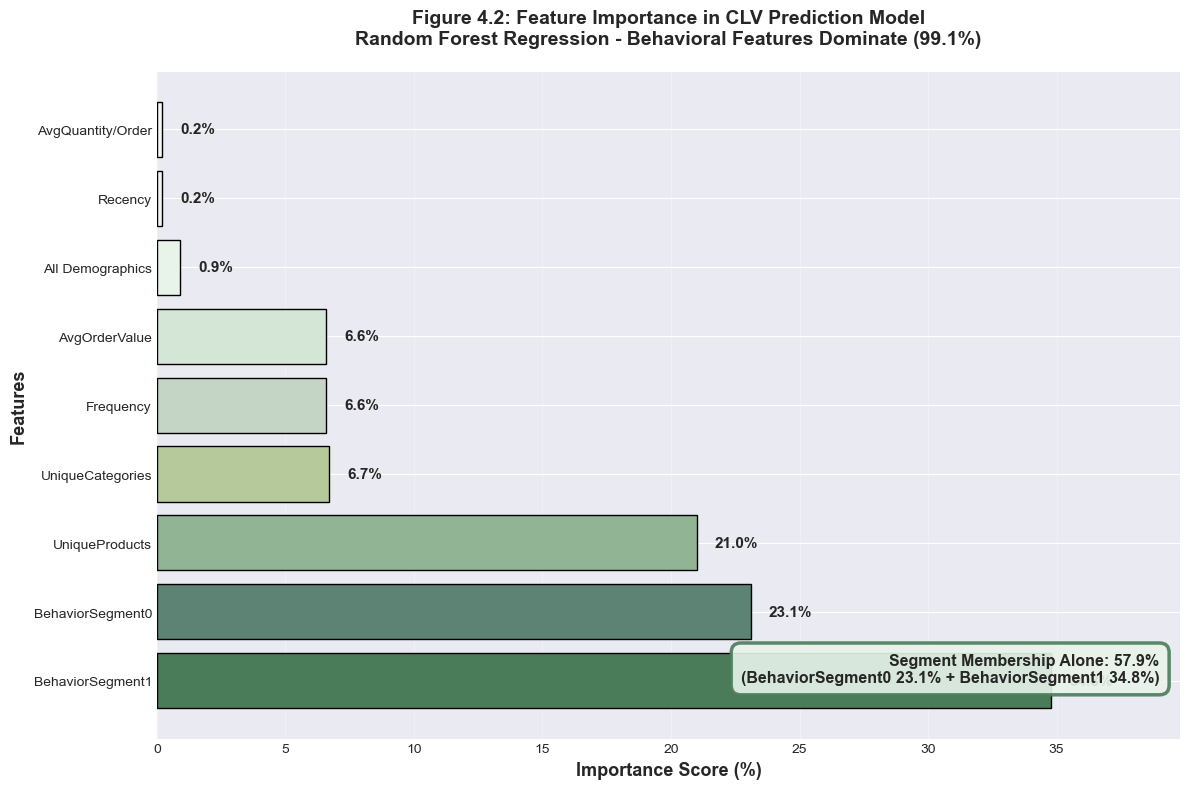

Figure 4.2 saved


In [54]:
features = ['BehaviorSegment1', 'BehaviorSegment0', 'UniqueProducts', 
            'UniqueCategories', 'Frequency', 'AvgOrderValue', 
            'All Demographics', 'Recency', 'AvgQuantity/Order']
importances = [34.8, 23.1, 21.0, 6.7, 6.6, 6.6, 0.9, 0.2, 0.2]

colors_feat = ['#4A7C59', '#5C8374', '#90B494', '#B5C99A', 
               '#C5D5C5', '#D4E7D7', '#E8F4EA', '#F0F4F0', '#F5F5F5']

fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.barh(features, importances, color=colors_feat, 
               edgecolor='black', linewidth=1)

ax.set_xlabel('Importance Score (%)', fontsize=13, fontweight='bold')
ax.set_ylabel('Features', fontsize=13, fontweight='bold')
ax.set_title('Figure 4.2: Feature Importance in CLV Prediction Model\nRandom Forest Regression - Behavioral Features Dominate (99.1%)', 
             fontsize=14, fontweight='bold', pad=20)

for bar, val in zip(bars, importances):
    ax.text(val + 0.7, bar.get_y() + bar.get_height()/2, 
            f'{val}%', va='center', fontsize=11, fontweight='bold')

textstr = 'Segment Membership Alone: 57.9%\n(BehaviorSegment0 23.1% + BehaviorSegment1 34.8%)'
props = dict(boxstyle='round,pad=0.6', facecolor='#E8F4EA', 
             alpha=0.9, edgecolor='#4A7C59', linewidth=2.5)
ax.text(0.98, 0.08, textstr, transform=ax.transAxes, fontsize=11.5,
        verticalalignment='bottom', horizontalalignment='right', 
        bbox=props, fontweight='bold')

ax.grid(axis='x', alpha=0.3, linewidth=0.8)
ax.set_xlim(0, max(importances) + 5)

plt.tight_layout()
plt.savefig('figure_4_2_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()
print("Figure 4.2 saved")

# CLV Distribution by Segment

/var/folders/cl/ff5rh4051lng0tpll0yl64q40000gn/T/ipykernel_95771/2372378331.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([segment_0_clv, segment_1_clv],


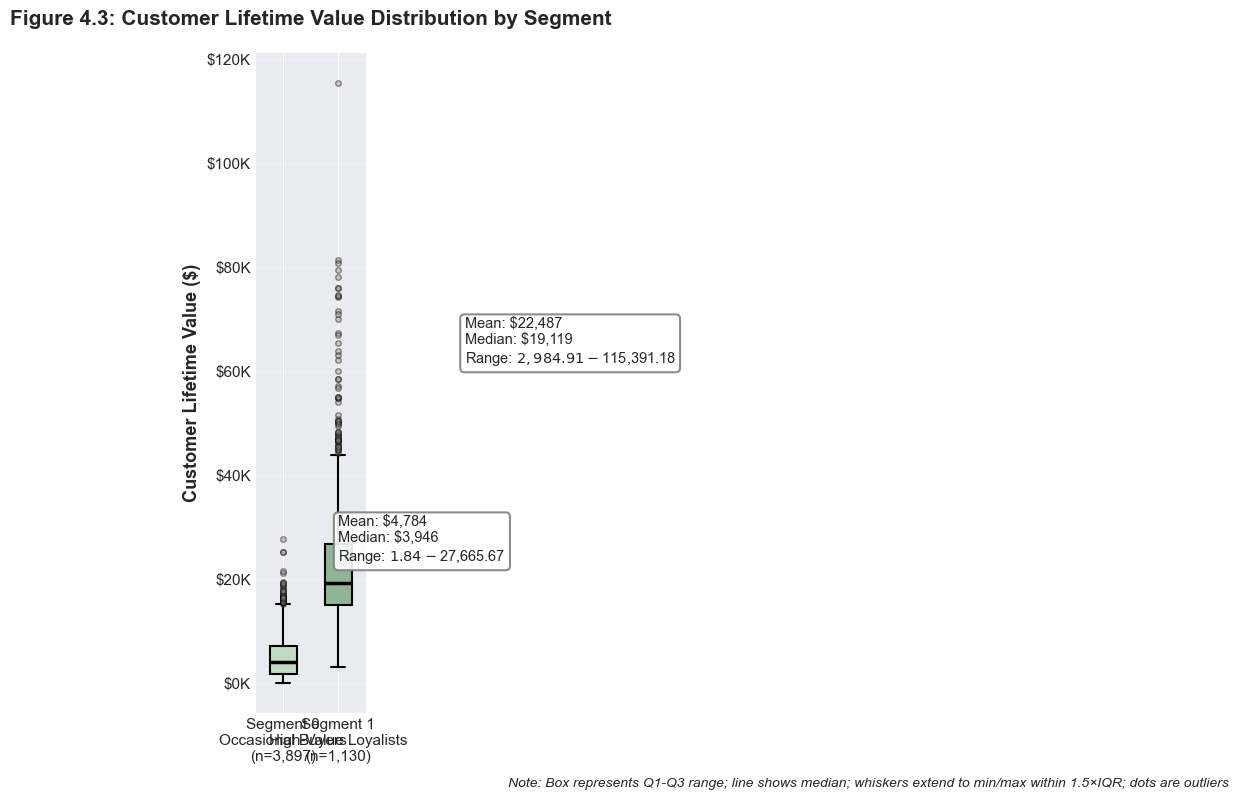

Figure 4.3 saved


In [57]:
segment_0_clv = df[df['Behavior_Segment'] == 0]['Total_Spent']
segment_1_clv = df[df['Behavior_Segment'] == 1]['Total_Spent']

fig, ax = plt.subplots(figsize=(14, 8))

bp = ax.boxplot([segment_0_clv, segment_1_clv], 
                labels=['Segment 0\nOccasional Buyers\n(n=3,897)', 
                       'Segment 1\nHigh-Value Loyalists\n(n=1,130)'],
                patch_artist=True,
                widths=0.5,
                showfliers=True,
                flierprops=dict(marker='o', markerfacecolor='gray', 
                               markersize=4, alpha=0.4),
                medianprops=dict(color='black', linewidth=2.5),
                boxprops=dict(linewidth=1.5),
                whiskerprops=dict(linewidth=1.5),
                capprops=dict(linewidth=1.5))

colors_box = ['#C0DAC4', '#90B494']
for patch, color in zip(bp['boxes'], colors_box):
    patch.set_facecolor(color)
    patch.set_edgecolor('black')

ax.set_ylabel('Customer Lifetime Value ($)', fontsize=13, fontweight='bold')
ax.set_title('Figure 4.3: Customer Lifetime Value Distribution by Segment', 
             fontsize=15, fontweight='bold', pad=20)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
ax.grid(axis='y', alpha=0.3, linewidth=0.8)
ax.tick_params(axis='both', labelsize=11)

seg0_stats = (f"Mean: ${segment_0_clv.mean():,.0f}\n"
              f"Median: ${segment_0_clv.median():,.0f}\n"
              f"Range: ${segment_0_clv.min():.2f}-${segment_0_clv.max():,.2f}")
seg1_stats = (f"Mean: ${segment_1_clv.mean():,.0f}\n"
              f"Median: ${segment_1_clv.median():,.0f}\n"
              f"Range: ${segment_1_clv.min():,.2f}-${segment_1_clv.max():,.2f}")

ax.text(0.75, 0.30, seg0_stats, transform=ax.transAxes, fontsize=10.5,
        verticalalignment='top', 
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, 
                 edgecolor='gray', linewidth=1.5))
ax.text(1.9, 0.60, seg1_stats, transform=ax.transAxes, fontsize=10.5,
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, 
                 edgecolor='gray', linewidth=1.5))

fig.text(0.5, 0.01, 
         'Note: Box represents Q1-Q3 range; line shows median; whiskers extend to min/max within 1.5×IQR; dots are outliers', 
         ha='center', fontsize=10, style='italic')

plt.tight_layout(rect=[0, 0.02, 1, 1])
plt.savefig('figure_4_3_clv_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print("Figure 4.3 saved")

/var/folders/cl/ff5rh4051lng0tpll0yl64q40000gn/T/ipykernel_95771/4185170332.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([segment_0_clv, segment_1_clv],


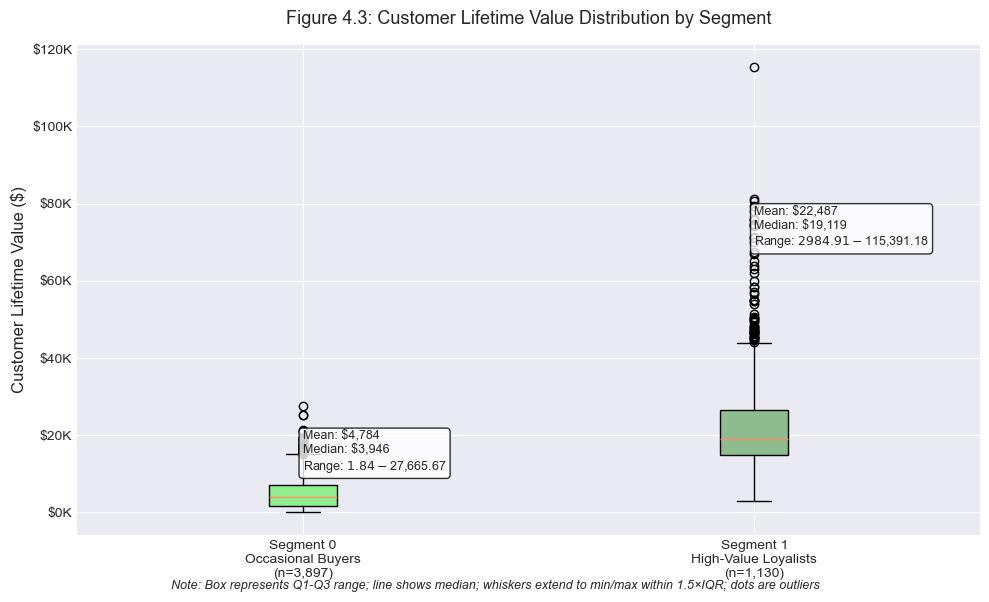

Figure 4.3 saved

Segment 0 Stats:
  Mean: $4,784.09
  Median: $3,946.19
  Range: $1.84 - $27,665.67

Segment 1 Stats:
  Mean: $22,486.74
  Median: $19,118.69
  Range: $2984.91 - $115,391.18


In [59]:

import matplotlib.pyplot as plt
import numpy as np

segment_0_clv = df[df['Behavior_Segment'] == 0]['Total_Spent']
segment_1_clv = df[df['Behavior_Segment'] == 1]['Total_Spent']

fig, ax = plt.subplots(figsize=(10, 6))

bp = ax.boxplot([segment_0_clv, segment_1_clv], 
                labels=['Segment 0\nOccasional Buyers\n(n=3,897)', 
                       'Segment 1\nHigh-Value Loyalists\n(n=1,130)'],
                patch_artist=True,
                showfliers=True)

colors = ['lightgreen', 'darkseagreen']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

ax.set_ylabel('Customer Lifetime Value ($)', fontsize=12)
ax.set_title('Figure 4.3: Customer Lifetime Value Distribution by Segment', 
             fontsize=13, pad=15)

ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

seg0_mean = segment_0_clv.mean()
seg0_median = segment_0_clv.median()
seg0_min = segment_0_clv.min()
seg0_max = segment_0_clv.max()

seg1_mean = segment_1_clv.mean()
seg1_median = segment_1_clv.median()
seg1_min = segment_1_clv.min()
seg1_max = segment_1_clv.max()

ax.text(1, seg0_max * 0.4, 
        f'Mean: ${seg0_mean:,.0f}\nMedian: ${seg0_median:,.0f}\nRange: ${seg0_min:.2f} - ${seg0_max:,.2f}',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
        fontsize=9)

ax.text(2, seg1_max * 0.6, 
        f'Mean: ${seg1_mean:,.0f}\nMedian: ${seg1_median:,.0f}\nRange: ${seg1_min:.2f} - ${seg1_max:,.2f}',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
        fontsize=9)

plt.figtext(0.5, 0.01, 
            'Note: Box represents Q1-Q3 range; line shows median; whiskers extend to min/max within 1.5×IQR; dots are outliers',
            ha='center', fontsize=9, style='italic')

plt.tight_layout()
plt.savefig('figure_4_3_clv_distribution_simple.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure 4.3 saved")
print(f"\nSegment 0 Stats:")
print(f"  Mean: ${seg0_mean:,.2f}")
print(f"  Median: ${seg0_median:,.2f}")
print(f"  Range: ${seg0_min:.2f} - ${seg0_max:,.2f}")
print(f"\nSegment 1 Stats:")
print(f"  Mean: ${seg1_mean:,.2f}")
print(f"  Median: ${seg1_median:,.2f}")
print(f"  Range: ${seg1_min:.2f} - ${seg1_max:,.2f}")